In [1]:
import torch
import gymnasium as gym
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
gym.__version__

'1.1.1'

In [4]:
class PolicyNetwork():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        self.model = nn.Sequential(
                        nn.Linear(n_state, n_hidden),
                        nn.ReLU(),
                        nn.Linear(n_hidden, n_action),
                        nn.Softmax(dim=-1),
                )
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)


    def predict(self, s):
        """
        Вычисляет вероятности действий в состоянии s, применяя обученную модель
        @param s: входное состояние
        @return: предсказанная стратегия
        """
        return self.model(torch.Tensor(s))


    def update(self, returns, log_probs):
        """
        Обновляет веса сети стратегии на основе обучающих примеров 
        @param returns: доход (накопительное вознаграждение) на каждом шаге эпизода
        @param log_probs: логарифмы вероятностей на каждом шаге
        """
        policy_gradient = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_gradient.append(-log_prob * Gt)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def get_action(self, s):
        """
        Предсказывает стратегию, выбирает действие и вычисляет логарифм его вероятности
        @param s: входное состояние
        @return: выбранное действие и логарифм его вероятности
        """
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class PolicyNetworkWithAttention(nn.Module):
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.001):
        super().__init__()

        self.n_state = n_state
        self.n_hidden = n_hidden

        self.linear_in = nn.Linear(n_state, n_hidden)
        self.query = nn.Linear(n_hidden, n_hidden)
        self.key = nn.Linear(n_hidden, n_hidden)
        self.value = nn.Linear(n_hidden, n_hidden)
        self.linear_out = nn.Linear(n_hidden, n_action)

        self.softmax = nn.Softmax(dim=-1)
        self.optimizer = torch.optim.Adam(self.parameters(), lr)

    def attention(self, x):
        # x shape: [batch, n_hidden]
        # для attention нужно добавить фиктивный seq dim → [batch, seq_len, dim]
        x = x.unsqueeze(1)

        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.n_hidden)  # [batch, 1, 1]
        weights = F.softmax(scores, dim=-1)
        attended = torch.matmul(weights, V)  # [batch, 1, hidden]

        return attended.squeeze(1)  # [batch, hidden]

    def parameters(self):
        return list(self.linear_in.parameters()) + \
               list(self.query.parameters()) + \
               list(self.key.parameters()) + \
               list(self.value.parameters()) + \
               list(self.linear_out.parameters())

    def predict(self, s):
        x = torch.Tensor(s).unsqueeze(0)  # добавляем batch dim
        x = F.relu(self.linear_in(x))
        x = self.attention(x)
        x = self.linear_out(x)
        probs = self.softmax(x).squeeze(0)
        return probs

    def update(self, returns, log_probs):
        policy_gradient = []
        for log_prob, Gt in zip(log_probs, returns):
            policy_gradient.append(-log_prob * Gt)

        loss = torch.stack(policy_gradient).sum()
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def get_action(self, s):
        probs = self.predict(s)
        action = torch.multinomial(probs, 1).item()
        log_prob = torch.log(probs[action])
        return action, log_prob

In [6]:
def reinforce(env, estimator, n_episode, gamma=1.0):
    """
    Алгоритм REINFORCE
    @param env: имя окружающей среды Gym
    @param estimator: сеть, аппроксимирующая стратегию
    @param n_episode: количество эпизодов
    @param gamma: коэффициент обесценивания
    """
    total_reward_episode = np.zeros(n_episode)
    
    for episode in tqdm(range(n_episode)):
        log_probs = []
        rewards = []
        state, _ = env.reset()

        while True:
            action, log_prob = estimator.get_action(state)
            next_state, reward, is_done, truncate, _ = env.step(action)

            total_reward_episode[episode] += reward
            log_probs.append(log_prob)
            rewards.append(reward)

            if is_done or truncate:

                returns = []

                Gt = 0
                pw = 0

                for reward in rewards[::-1]:
                    Gt += gamma ** pw * reward
                    pw += 1
                    returns.append(Gt)

                returns = returns[::-1]
                returns = torch.tensor(returns)
                returns = (returns - returns.mean()) / (
                    returns.std() + 1e-9)

                estimator.update(returns, log_probs)
                break

            state = next_state
    return total_reward_episode

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:23<00:00,  4.92it/s]


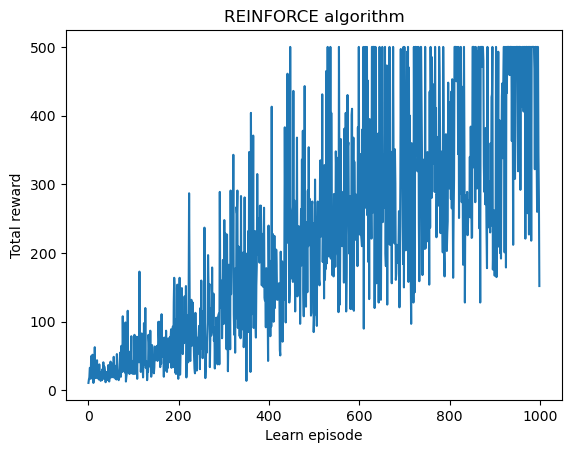

In [7]:
env = gym.make('CartPole-v1')
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 256
lr = 0.0001
policy_net = PolicyNetwork(n_state, n_action, n_hidden, lr)
policy_net = PolicyNetworkWithAttention(n_state, n_action, n_hidden, lr)

n_episode = 1000
gamma = 0.99

total_reward_episode = reinforce(env, policy_net, n_episode, gamma)

plt.plot(total_reward_episode)
plt.title('REINFORCE algorithm')
plt.xlabel('Learn episode')
plt.ylabel('Total reward')
plt.show()

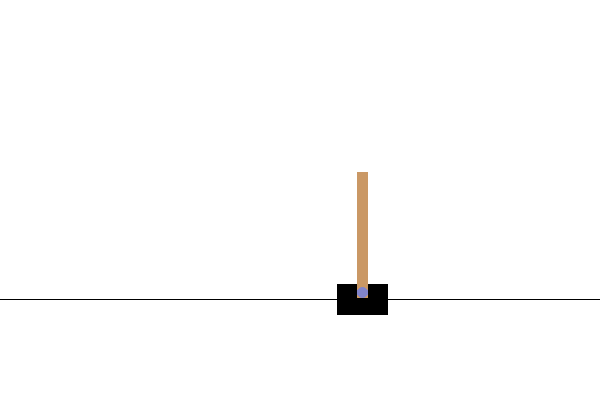

In [ ]:
from PIL import Image
from IPython.display import display, clear_output
import time

env = gym.make("CartPole-v1", render_mode="rgb_array")
state, _ = env.reset()
total_reward = 0

policy_net.eval()

for t in range(500):
    frame = env.render()
    img = Image.fromarray(frame)
    clear_output(wait=True)
    display(img)
    time.sleep(0.03)

    with torch.no_grad():
        probs = policy_net.predict(state)  # shape: [n_action]
        action = torch.argmax(probs).item()  # детерминированно

    state, reward, done, truncated, _ = env.step(action)
    total_reward += reward

    if done or truncated:
        break

env.close()
print(f"Total reward: {total_reward}")
